# Imports

### PR Lab 2
Abdelrahman Elsayed - 20010795
Mohamed Amr Abdelfattah - 20011675
Omar Tarek Abdelwahab - 20010998

In [ ]:
import zipfile
import pandas as pd
import os
from numpy import asarray
import numpy as np
from typing_extensions import Text
from sklearn.metrics import accuracy_score
from math import log2, comb
from numpy.linalg import *

# Setup

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp /content/drive/MyDrive/kaggle_token/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download obirgul/daily-and-sports-activities

daily-and-sports-activities.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip daily-and-sports-activities.zip

Archive:  daily-and-sports-activities.zip
replace data/a01/p1/s01.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# reading each file
# then converting it to a row vector
rows_list_segments = []
files_activity = np.sort((os.listdir(f"data")))
for activity in files_activity:
 files_person = np.sort(os.listdir(f"data/{activity}"))
 for person in files_person:
  segments = np.sort(os.listdir(f"data/{activity}/{person}"))
  for segment in segments:
      text_content =  np.loadtxt(f"data/{activity}/{person}/{segment}", delimiter=',')
      rows_list_segments.append(
        asarray(text_content).reshape(( 125*45))
      )
rows_list_segments = np.array(rows_list_segments)
print(rows_list_segments.shape)

(9120, 5625)


get data with take mean for every colomn in the segment so that the data will be 9120  * 45

In [ ]:
# get the data with the mean
list_segments_mean = []
files_activity = np.sort((os.listdir(f"data")))
for activity in files_activity:
 files_person = np.sort(os.listdir(f"data/{activity}"))
 for person in files_person:
  segments = np.sort(os.listdir(f"data/{activity}/{person}"))
  for segment in segments:
      text_content =  np.loadtxt(f"data/{activity}/{person}/{segment}", delimiter=',')
      row_means = np.mean(text_content, axis=0)
      list_segments_mean.append(
        asarray(row_means)
      )
list_segments_mean = np.array(list_segments_mean)


**Spliting Data**



Split data to take first 48 segments for training and next 12 segments for testing

In [ ]:
def split_data(data_matrix):
  training_data = []
  training_labels = []
  testing_data = []
  testing_labels = []
  count = 1
  label = 0
  for i in range (0,9120):
    if count <= 48:
      training_data.append(data_matrix[i])
      training_labels.append(int(label/8))
    else:
      testing_data.append(data_matrix[i])
      testing_labels.append(int(label/8))
    if count >= 60:
      count = 0
      label +=1
    count += 1
  training_data = np.array(training_data)
  testing_data = np.array(testing_data)
  training_labels = np.array(training_labels)
  testing_labels = np.array(testing_labels)
  print(testing_labels)
  return training_data,training_labels,testing_data,testing_labels


In [ ]:
#get the data
training_data,training_labels,testing_data,testing_labels= split_data(rows_list_segments)



[ 0  0  0 ... 18 18 18]


In [ ]:
#Get the data with mean
training_data_mean,training_labels,testing_data_mean,testing_labels = split_data(list_segments_mean)

[ 0  0  0 ... 18 18 18]


To centralize data to be between 0 and 1

In [ ]:
def min_max_normalize(data):
    # Find the minimum and maximum values for each attribute
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Apply min-max normalization
    normalized_data = (data - min_vals) / (max_vals - min_vals)

    return normalized_data

K_means with first method with taking average

In [ ]:
def k_means(data, k, max_iters):
    # Randomly initialize centroids
    #choice in range of raws of data
    # number of centroids equal number of clusters
    # replace = false cannot choice the same point
    # centroids = data[np.random.choice(data.shape[0], k, replace=False)]
    # centroids = np.array(centroids)
    centroids_index = np.arange(0, data.shape[0], data.shape[0]/k)
    if len(centroids_index) != k:
      for i in range(k-len(centroids)):
        centroids_index.append(np.random.choice(data.shape[0], 1, replace=False))
    centroids = []
    for i in centroids_index:
      centroids.append(data[int(i)])
    centroids = np.array(centroids)
    print(len(centroids))
    for it in range(max_iters):
        # Assign each data point to the nearest centroid
        distance = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distance, axis=0)
        # Update centroids
        new_centroids = np.array([data[labels == i].mean(axis=0) for i in range(k)])
        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels





K_means for second method with PCA

In [ ]:
def sort_eigen(eigenvalues, eigenvectors):
  idx = eigenvalues.argsort()[::-1]
  sorted_eval = eigenvalues[idx]
  sorted_evec = eigenvectors[:,idx]
  return sorted_eval, sorted_evec

def reduce_dimensionality(cov_eigenval, cov_eigenvec, alpha):
  # returns the projection matrix for given alpha
  # eigenvalues and eigenvectors must be sorted

  total_variance = np.sum(cov_eigenval)

  # current sum of chosen dominant eigenvalues
  curr_eigensum = 0
  # index to eigenvalue index list
  curr_eig_index = 0

  while curr_eigensum / total_variance < alpha:
    #updating the dominant eigenvalues sum
    curr_eigensum +=  cov_eigenval[curr_eig_index]
    curr_eig_index += 1

  return cov_eigenvec.T[:curr_eig_index + 1].T
  # return cov_eigenvec.T[:curr_eig_index + 1].T.real


def covariance_eigens_from_data(data: np.ndarray):
  """
  input:
    - training data matrix (n*d)
  output:
    - eigenvalues and eigenvectors of the covaraince matrix (d*d).
  """
  n, d = data.shape
  mean_vec = data.T @ np.ones((n, 1)) / n
  centered_data = data - np.ones((n, 1)) @ mean_vec.T
  #d*d --> very large, needs to be optimized
  covariance_mat = centered_data.T @ centered_data / n
  return eigh(covariance_mat)


Use the centroid to cluster the test data

In [ ]:
def k_means_test(data, centroids):
        # Assign each data point to the nearest centroid
        distance = np.sqrt(((data - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distance, axis=0)
        return  labels


Evaluation

In [ ]:
def get_clusters(prediction_labels, k):
  clusters = []
  for i in range(k):
    clusters.append([x for x in range(len(prediction_labels)) if prediction_labels[x] == i])
  return clusters

In [ ]:
def get_actual_cluster_index(sample, ground_truth):
  for i in range(len(ground_truth)):
    if(sample in ground_truth[i]):
      return i
  raise Exception(f"Element {sample} not found in ground_truth {ground_truth}")

In [ ]:
def get_types_counts_in_cluster(labels, cluster):
  counts = {}
  for sample in cluster:
    actual_cluster_index_of_sample = get_actual_cluster_index(sample, labels)
    if actual_cluster_index_of_sample in counts:
      counts[actual_cluster_index_of_sample] += 1
    else:
      counts[actual_cluster_index_of_sample] = 1
  return counts

In [ ]:
#Entropy
#H(T|Ci) = sum over all types(n(Tj)/n(Ci))
def entropy(ground_truth, clusters):
  total_samples = sum([len(lst) for lst in ground_truth])
  ent = 0
  for cluster in clusters:
    acc = 0
    # counts for each actual cluster type in a cluster
    counts = get_types_counts_in_cluster(ground_truth, cluster)
    for type_key in counts:
      p = counts[type_key]/len(cluster)
      if p == 0:
        continue
      acc += p * log2(p)
    ent += -acc*(len(cluster)/total_samples)
  return ent

In [ ]:
# get the ground truth
# size = 48 for training or 12 for test number of segment per person
def get_ground_truth(size):
  size = size*8
  ground_truth = []
  for i in range(19):
    ground_truth.append([i*size+j for j in range (size) ])
  return ground_truth



In [ ]:
def get_dominant_type_in_cluster(ground_truth, cluster):
  counts = get_types_counts_in_cluster(ground_truth, cluster)
  return max(counts), counts[max(counts)]

In [ ]:
#get recall
def get_recall_of_cluster(ground_truth, cluster):
  dominant_type, dominant_count_in_cluster = get_dominant_type_in_cluster(ground_truth, cluster)
  return dominant_count_in_cluster / len(ground_truth[dominant_type])

In [ ]:
# get precision of one cluster
def get_precision_of_cluster(ground_truth, cluster):
  dominant_type, dominant_count_in_cluster = get_dominant_type_in_cluster(ground_truth, cluster)
  return dominant_count_in_cluster / len(cluster)

In [ ]:
# get f measure of all clusters
def get_f(ground_truth, clusters):
  acc = 0
  for cluster in clusters:
    precision = get_precision_of_cluster(ground_truth, cluster)
    recall = get_recall_of_cluster(ground_truth, cluster)
    acc += (precision * recall) / ((precision + recall) / 2)
  return acc / len(clusters)

To evaluate the first method of K_means

In [ ]:

def evaluate_kmeans(k,data,size):
  # Run K-means algorithm
  centroids, prediction_labels = k_means((data), k, 5000)
  clusters_matrix = get_clusters(prediction_labels,k)
  ground_truth = get_ground_truth(size)
  total_recall = 0
  total_precision = 0
  for i in range (k):
    # print("For cluster ",i,": ")
    # print("size of cluster = ",len(clusters_matrix[i]))
    total_recall += (len(clusters_matrix[i]) / len(prediction_labels))*get_recall_of_cluster(ground_truth,clusters_matrix[i])
    # print("recall of cluster = ",get_recall_of_cluster(ground_truth,clusters_matrix[i]))
    total_precision += (len(clusters_matrix[i]) / len(prediction_labels))*get_precision_of_cluster(ground_truth,clusters_matrix[i])
    # print("precision of cluster = ",get_precision_of_cluster(ground_truth,clusters_matrix[i]))
    # print("-----------------------------------------------------------------------------------------------------")
  print("For all clusters with k = ",k)
  print("Entropy = ",entropy( ground_truth,get_clusters(prediction_labels,k)))
  print("Recall = ",total_recall)
  print("Precision = ",total_precision)
  print("F_measure of all clusters = ",get_f(ground_truth,clusters_matrix))
  print("-----------------------------------------------------------------------------------------------------")
  return centroids, prediction_labels



In [ ]:
# For evaluate By using different k
klist = [8, 13, 19, 28,38]
for i in klist:
  evaluate_kmeans(i,training_data_mean,48)

8
For all clusters with k =  8
Entropy =  2.4672518907095102
Recall =  0.41007165741502194
Precision =  0.21052631578947367
F_measure of all clusters =  0.41081965826899436
-----------------------------------------------------------------------------------------------------
13
For all clusters with k =  13
Entropy =  2.012362640479033
Recall =  0.3324724163925438
Precision =  0.26247258771929827
F_measure of all clusters =  0.34575383224286776
-----------------------------------------------------------------------------------------------------
19
For all clusters with k =  19
Entropy =  1.8914538993066239
Recall =  0.28079419944718564
Precision =  0.2694627192982456
F_measure of all clusters =  0.2720551311234692
-----------------------------------------------------------------------------------------------------
28
For all clusters with k =  28
Entropy =  1.6793510532875124
Recall =  0.24353419967562132
Precision =  0.33538925438596495
F_measure of all clusters =  0.2729208958923218
-

In [ ]:
# For evaluate By using different k for testing
klist = [8, 13, 19, 28,38]
for i in klist:
  evaluate_kmeans(i,testing_data_mean,12)

8
For all clusters with k =  8
Entropy =  2.4204001061925755
Recall =  0.37512563961988304
Precision =  0.21052631578947367
F_measure of all clusters =  0.43746617101368673
-----------------------------------------------------------------------------------------------------
13
For all clusters with k =  13
Entropy =  2.0113795793775964
Recall =  0.38983689692982454
Precision =  0.30043859649122806
F_measure of all clusters =  0.39211235924179016
-----------------------------------------------------------------------------------------------------
19
For all clusters with k =  19
Entropy =  1.8233372324763941
Recall =  0.3464226973684211
Precision =  0.3009868421052631
F_measure of all clusters =  0.29365966190133586
-----------------------------------------------------------------------------------------------------
28
For all clusters with k =  28
Entropy =  1.5366126618100957
Recall =  0.28811449195906425
Precision =  0.37499999999999994
F_measure of all clusters =  0.2975315053364712

the best accuracy when the k = 8 so will use its centroids to evaluate in the the test data
For all clusters with k =  8
Entropy =  2.4672518907095102
Recall =  0.41007165741502194
Precision =  0.21052631578947367
F_measure of all clusters =  0.41081965826899436


In [ ]:
centroids, prediction_labels_training = evaluate_kmeans(8,training_data_mean,48)
prediction_labels = k_means_test(testing_data_mean,centroids)
total_recall = 0
total_precision = 0
clusters_matrix = get_clusters(prediction_labels,8)
ground_truth = get_ground_truth(12)
for i in range (8):
    # print("For cluster ",i,": ")
    # print("size of cluster = ",len(clusters_matrix[i]))
    total_recall += (len(clusters_matrix[i]) / len(prediction_labels))*get_recall_of_cluster(ground_truth,clusters_matrix[i])
    # print("recall of cluster = ",get_recall_of_cluster(ground_truth,clusters_matrix[i]))
    total_precision += (len(clusters_matrix[i]) / len(prediction_labels))*get_precision_of_cluster(ground_truth,clusters_matrix[i])
    # print("precision of cluster = ",get_precision_of_cluster(ground_truth,clusters_matrix[i]))
    # print("-----------------------------------------------------------------------------------------------------")
print("For all clusters with k = ",8)
print("Entropy = ",entropy( ground_truth,get_clusters(prediction_labels,8)))
print("Recall = ",total_recall)
print("Precision = ",total_precision)
print("F_measure of all clusters = ",get_f(ground_truth,clusters_matrix))
print("-----------------------------------------------------------------------------------------------------")

8
For all clusters with k =  8
Entropy =  2.4672518907095102
Recall =  0.41007165741502194
Precision =  0.21052631578947367
F_measure of all clusters =  0.41081965826899436
-----------------------------------------------------------------------------------------------------
For all clusters with k =  8
Entropy =  2.4782823161714713
Recall =  0.4269462719298245
Precision =  0.2105263157894737
F_measure of all clusters =  0.4131882089260813
-----------------------------------------------------------------------------------------------------


After using the centroids of the data training to evaluate the data test we get
Entropy =  2.4782823161714713
Recall =  0.4269462719298245
Precision =  0.2105263157894737
F_measure of all clusters =  0.4131882089260813

To evaluate the second method of K_means by Using PCA

In [ ]:
def pca (training_data,alpha,k):
  # eigens from pca
  eigenval, eigenvec = covariance_eigens_from_data(training_data)

  #sorting eigens
  sorted_eigenval, sorted_eigenvec = sort_eigen(eigenval, eigenvec)
  # projection matrix
  proj_mat = reduce_dimensionality(sorted_eigenval, sorted_eigenvec, alpha)
  # reduction of training and testing data
  reduced_training = training_data @ proj_mat

  centroids, prediction_labels = k_means((reduced_training), k, 100)
  return centroids, prediction_labels,proj_mat

In [ ]:
def evaluate_kmeans_pca(k,data,size):
  centroids,prediction_labels,proj_mat = pca(data,0.8,k)
  clusters_matrix = get_clusters(prediction_labels,k)
  ground_truth = get_ground_truth(size)
  total_recall = 0
  total_precision = 0
  print("BY using PCA")
  for i in range (k):
    # print("For cluster ",i,": ")
    # print("size of cluster = ",len(clusters_matrix[i]))
    total_recall += (len(clusters_matrix[i]) / len(prediction_labels))*get_recall_of_cluster(ground_truth,clusters_matrix[i])
    # print("recall of cluster = ",get_recall_of_cluster(ground_truth,clusters_matrix[i]))
    total_precision += (len(clusters_matrix[i]) / len(prediction_labels))*get_precision_of_cluster(ground_truth,clusters_matrix[i])
    # print("precision of cluster = ",get_precision_of_cluster(ground_truth,clusters_matrix[i]))
    # print("-----------------------------------------------------------------------------------------------------")
  print("For all clusters k = ",k)
  print("Entropy = ",entropy(get_ground_truth(size),get_clusters(prediction_labels,k)))
  print("Recall = ",total_recall)
  print("Precision = ",total_precision)
  print("F_measure of all clusters = ",get_f(ground_truth,clusters_matrix))
  print("-----------------------------------------------------------------------------------------------------")
  return centroids,proj_mat



In [ ]:
# For evaluate By using different k
klist = [8, 13, 19, 28 ,38]
for i in klist:
  evaluate_kmeans_pca(i,training_data,48)

8
BY using PCA
For all clusters k =  8
Entropy =  2.531197279514675
Recall =  0.4926183154011331
Precision =  0.17420504385964913
F_measure of all clusters =  0.30570409068656884
-----------------------------------------------------------------------------------------------------
13
BY using PCA
For all clusters k =  13
Entropy =  2.338343754980535
Recall =  0.4017555281432748
Precision =  0.2416392543859649
F_measure of all clusters =  0.3191353571147086
-----------------------------------------------------------------------------------------------------
19
BY using PCA
For all clusters k =  19
Entropy =  1.9977384632888011
Recall =  0.4202652423702484
Precision =  0.33086622807017546
F_measure of all clusters =  0.34478359112045687
-----------------------------------------------------------------------------------------------------
28
BY using PCA
For all clusters k =  28
Entropy =  1.7627900251268345
Recall =  0.2766138266401681
Precision =  0.34333881578947373
F_measure of all clus

Compare between k means when average data and flatten data and use pca to reduce the dimensions (testing data)
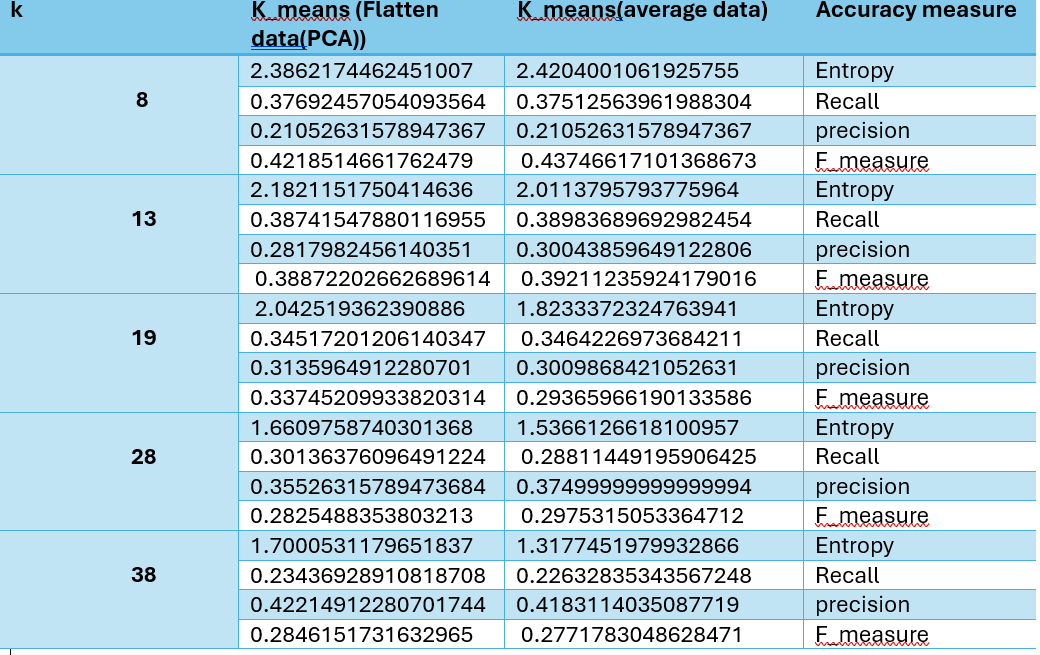

Compare between k means when average data and flatten data and use pca to reduce the dimensions (training data)
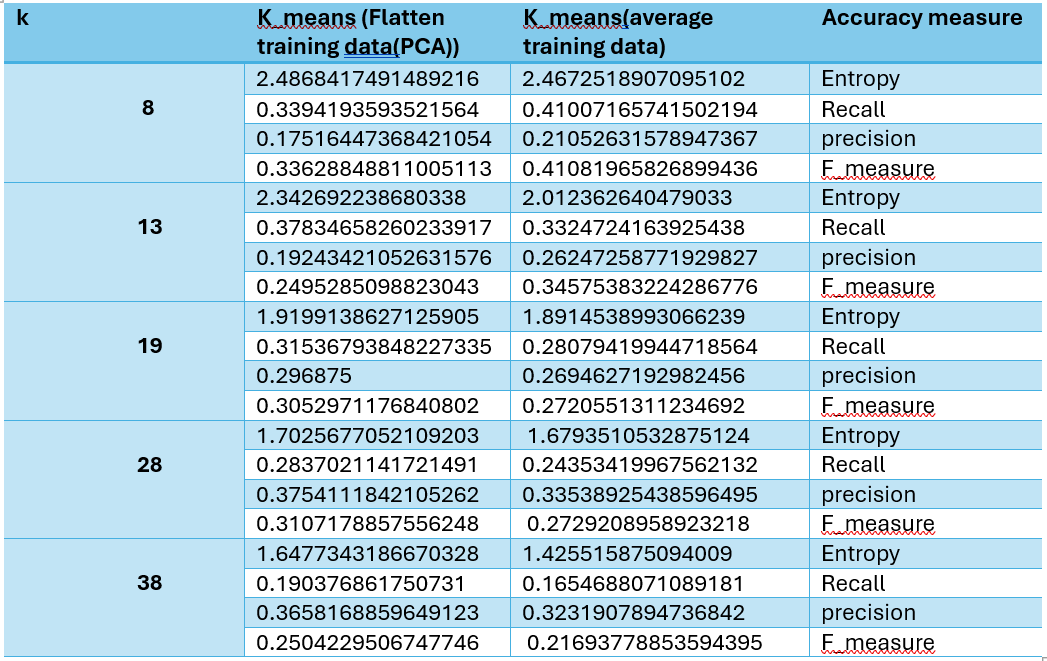

the best accuracy when the k = 8 so will use its centroids to evaluate in the the test data For all clusters with k = 8
For all clusters k =  8
Entropy =  2.4868417491489216
Recall =  0.3394193593521564
Precision =  0.17516447368421054
F_measure of all clusters =  0.33628848811005113

In [ ]:
centroids,proj_mat  = evaluate_kmeans_pca(8)
prediction_labels = k_means_test(testing_data @ proj_mat ,centroids)
total_recall = 0
total_precision = 0
clusters_matrix = get_clusters(prediction_labels,8)
ground_truth = get_ground_truth(12)
for i in range (8):
    # print("For cluster ",i,": ")
    # print("size of cluster = ",len(clusters_matrix[i]))
    total_recall += (len(clusters_matrix[i]) / len(prediction_labels))*get_recall_of_cluster(ground_truth,clusters_matrix[i])
    # print("recall of cluster = ",get_recall_of_cluster(ground_truth,clusters_matrix[i]))
    total_precision += (len(clusters_matrix[i]) / len(prediction_labels))*get_precision_of_cluster(ground_truth,clusters_matrix[i])
    # print("precision of cluster = ",get_precision_of_cluster(ground_truth,clusters_matrix[i]))
    # print("-----------------------------------------------------------------------------------------------------")
print("For all clusters with k = ",8)
print("Entropy = ",entropy( ground_truth,get_clusters(prediction_labels,8)))
print("Recall = ",total_recall)
print("Precision = ",total_precision)
print("F_measure of all clusters = ",get_f(ground_truth,clusters_matrix))
print("-----------------------------------------------------------------------------------------------------")

8
BY using PCA
For all clusters k =  8
Entropy =  2.4868417491489216
Recall =  0.3394193593521564
Precision =  0.17516447368421054
F_measure of all clusters =  0.33628848811005113
-----------------------------------------------------------------------------------------------------
For all clusters with k =  8
Entropy =  2.5136207330581244
Recall =  0.34054047880116955
Precision =  0.16447368421052633
F_measure of all clusters =  0.290630706512335
-----------------------------------------------------------------------------------------------------


After using the centroids of the data training to evaluate the data test we get
For all clusters with k =  8
Entropy =  2.5136207330581244
Recall =  0.34054047880116955
Precision =  0.16447368421052633
F_measure of all clusters =  0.290630706512335

**Second Method NCUT**

In [ ]:
def rbf_kernel(x, y, gamma = 1):
  nrm = np.linalg.norm(x - y)
  nrm = nrm**2
  return np.exp(-gamma*nrm)

In [ ]:
def similarity_matrix(data):
  n, d = data.shape
  A = np.zeros((n, n))
  for i in range(n):
    x = data[i]
    for j in range(i, n):
      y = data[j]
      A[i][j] = rbf_kernel(x, y)
      A[j][i] = A[i][j]
  return A

In [ ]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [ ]:
# function to ncut method
def ncut(data):
  A = similarity_matrix(min_max_normalize(data))
  Δ = np.sum(A, axis=1)
  Δ = np.diag(Δ)
  L = Δ - A
  La = np.linalg.inv(Δ).dot(L)
  eigen_values, eigen_vectors = np.linalg.eig(La)
  return eigen_values,eigen_vectors

In [ ]:
def sort_eigen(eigenvalues, eigenvectors):
  idx = eigenvalues.argsort()
  sorted_eval = eigenvalues[idx]
  sorted_evec = eigenvectors.T[idx].T
  return sorted_eval, sorted_evec

In [ ]:
# to normalize the matrix
def normalize(arr):
    d = arr.shape[1]
    for row in arr:
        nrm = np.linalg.norm(row)
        for ind in range(d):
            row[ind] /= nrm
    return arr

In [ ]:
#Then get the eigen_values and vectors and use k means
def clustering_ncuts(k):
  eigen_values,eigen_vectors = ncut(testing_data_mean)
  sorted_eval,sorted_evec = sort_eigen(eigen_values,eigen_vectors.real)
  normalized_eigenvectors = min_max_normalize(sorted_evec.T[:k].T)
  evaluate_kmeans(k, normalized_eigenvectors,12)


In [ ]:
# Try for different k
klist = [19]
for i in klist:
  clustering_ncuts(i)

19
For all clusters with k =  19
Entropy =  1.7877166006099499
Recall =  0.3093247441520468
Precision =  0.2839912280701754
F_measure of all clusters =  0.30127937351276435
-----------------------------------------------------------------------------------------------------


After multi run of ncut we found the best gamma is 1 so we use it in clustering
and then compare with k means for testing mean data
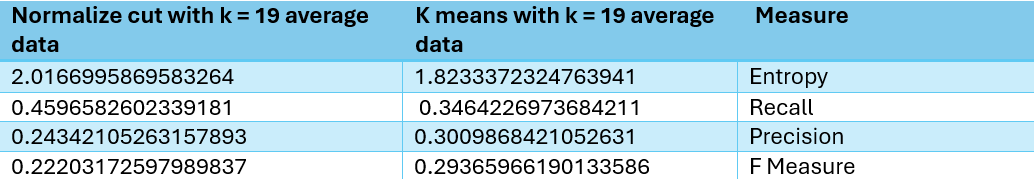

Run for pca for testing data

In [ ]:
#Then get the eigen_values and vectors and use k means
def clustering_ncuts(k):
  eigen_values,eigen_vectors = ncut(testing_data_mean)
  sorted_eval,sorted_evec = sort_eigen(eigen_values,eigen_vectors.real)
  normalized_eigenvectors = min_max_normalize(sorted_evec.T[:k].T)
  evaluate_kmeans(k, normalized_eigenvectors,12)

**Part 3**

In [ ]:
import numpy as np
from numpy.random import choice
from scipy.stats import multivariate_normal
def init_params(k, data_mat):
  """
  k: number of clusters
  data_mat: nd data matrix

  returns for each cluster 3 parameters:
  mean: row vector (1d) chosen as a random element from the dataset
  cov: initialized as the identity matrix
  size: initialized as 1/k (all clusters are equal)
  """

  n, d = data_mat.shape
  params = []
  random_row_indices = choice(n, k, replace=False)
  for i in range(k):
    mean = data_mat[random_row_indices[i]]
    cov = np.identity(d)
    params.append((mean, cov, 1/k))

  return params


In [ ]:
def calc_posteriors_for_sample(x, clusters_distr, gaussians):
  """
  calculates (p(C = c_i | X = x_i))
  the probability that xi belongs to cluster ci
  for A SINGLE SAMPLE
  for all clusters
   """
  p_list = []
  for i in range(len(gaussians)):
    # mean, cov, size = cluster
    size = clusters_distr[i][2]
    # gaussian = multivariate_normal(mean, cov, allow_singular=True)
    p_list.append(size * gaussians[i].pdf(x))

  # print(p_list)
  p_sum = sum(p_list)

  # print(p_sum)

  posteriors_list = []
  for p in p_list:
    if p_sum == 0:
      posteriors_list.append(p)
    else:
      posteriors_list.append(p / p_sum)
  return posteriors_list


In [ ]:
def calculate_posteriors_matrix(data_mat, clusters_distr):
  """
  priors matrix: n*c
  n: number of samples
  c: number of clusters
  each row represents priors of a sample for all clusters
  """
  n, d = data_mat.shape

  gaussians = []
  for i in range(len(clusters_distr)):
    mean, cov, size = clusters_distr[i]
    gauss = multivariate_normal(mean, cov, allow_singular=True)
    gaussians.append(gauss)

  priors_list = []
  for i in range(n):
    priors_list.append(calc_posteriors_for_sample(data_mat[i], clusters_distr, gaussians))
  return np.vstack(priors_list)

In [ ]:
def calc_clusters_probability(posteriors_matrix, number_of_samples):
  return np.sum(posteriors_matrix, axis=0) / number_of_samples

In [ ]:
def calc_mean_of_cluster(cluster_index, data_mat, posteriors_matrix, clusters_probability):

  """
  returns the mean vector for a single cluster
  shape = (d,)
  """

  #number_of_samples
  n, d = data_mat.shape
  posteriors_of_cluster = posteriors_matrix[:, cluster_index]
  mean = np.zeros((d,))
  for i in range(n):
    mean += posteriors_of_cluster[i] * data_mat[i]
  # normalize by mc = posterior * number of samples
  mean *= 1 / (n * clusters_probability[cluster_index])
  return mean

In [ ]:
def calc_covariance_of_cluster(cluster_index, data_mat, posteriors_matrix, clusters_probability, cluster_mean):

  """
  returns the covariance matrix for a single cluster
  shape = (d,d)
  """

  n,d = data_mat.shape
  posteriors_of_cluster = posteriors_matrix[:, cluster_index]
  cov = np.zeros((d,d))
  for i in range(n):
    centered_sample = (data_mat[i] - cluster_mean).reshape((1,d))
    cov += posteriors_of_cluster[i] * (centered_sample.T @ centered_sample)
  # normalize by mc = posterior * number of samples
  cov *= 1 / (n * clusters_probability[cluster_index])
  return cov

In [ ]:
def get_updated_params(k, data_mat, posteriors_mat, clusters_probability):
  """
  returns the new parameters of each cluster
  after the maximization step
  list of length k, each entry is a tuple (mean, var, size)
  """
  updated_params = []

  for i in range(k):
    mean = calc_mean_of_cluster(i, data_mat, posteriors_mat, clusters_probability)
    var = calc_covariance_of_cluster(i, data_mat, posteriors_mat, clusters_probability, mean)
    size = clusters_probability[i]
    updated_params.append((mean, var, size))

  return updated_params

In [ ]:
def gmm(k, data_mat, epochs):
  """
  returns a list of parameters (mean, var, size) for each cluster
  after performing EM algorithm epochs times
  """

  params = init_params(k, data_mat)
  # print("initial parameteres")
  # print(params)

  n, d = data_mat.shape

  for i in range(epochs):
    # Expectation step
    posteriors_mat = calculate_posteriors_matrix(data_mat, params)
    clusters_probability = calc_clusters_probability(posteriors_mat, n)
    # print(posteriors_mat)
    # Maximization step
    params = get_updated_params(k, data_mat, posteriors_mat, clusters_probability)

    # print(params)

  return params


In [ ]:
def gmm_predict(x, clusters_param, gaussians):

  """
  returns the index of the cluster with the maximum
  p(ci | x)

  accepts a vector x and a list of parameters for each cluster
  each has (mean, cov, size)

  """

  p_list = []
  for i in range(len(clusters_param)):
    mean, cov, size = clusters_param[i]
    p_list.append(size * gaussians[i].pdf(x))
  return np.argmax(p_list)

In [ ]:
parms = gmm(19, training_data_mean,50)

In [ ]:

some_gaussians = []
for i in range(19):
  mean, cov, size = parms[i]
  some_gaussians.append(multivariate_normal(mean, cov, allow_singular=True))
gmm_labels = []
for i in range (testing_data_mean.shape[0]):
  gmm_labels.append(gmm_predict(testing_data_mean[i],parms,some_gaussians))
print(gmm_labels)


[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 10, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 17, 17, 17, 17, 17, 17, 17, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 0, 0, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 12, 12, 12, 12, 12, 12, 0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 12, 12, 12, 12, 12, 12, 12, 12,

In [ ]:
# calculate the accuracy
total_recall = 0
total_precision = 0
prediction_labels = gmm_labels
clusters_matrix = get_clusters(prediction_labels,19)
ground_truth = get_ground_truth(12)
for i in range (19):
    # print("For cluster ",i,": ")
    # print("size of cluster = ",len(clusters_matrix[i]))
    total_recall += (len(clusters_matrix[i]) / len(prediction_labels))*get_recall_of_cluster(ground_truth,clusters_matrix[i])
    # print("recall of cluster = ",get_recall_of_cluster(ground_truth,clusters_matrix[i]))
    total_precision += (len(clusters_matrix[i]) / len(prediction_labels))*get_precision_of_cluster(ground_truth,clusters_matrix[i])
    # print("precision of cluster = ",get_precision_of_cluster(ground_truth,clusters_matrix[i]))
    # print("-----------------------------------------------------------------------------------------------------")
print("For all clusters with k = ",19)
print("Entropy = ",entropy( ground_truth,get_clusters(prediction_labels,19)))
print("Recall = ",total_recall)
print("Precision = ",total_precision)
print("F_measure of all clusters = ",get_f(ground_truth,clusters_matrix))
print("-----------------------------------------------------------------------------------------------------")

For all clusters with k =  19
Entropy =  2.0141658524040786
Recall =  0.42383954678362573
Precision =  0.33826754385964913
F_measure of all clusters =  0.352784741820377
-----------------------------------------------------------------------------------------------------


the accurcy of the gmm model
For all clusters with k =  19
Entropy =  2.0141658524040786
Recall =  0.42383954678362573
Precision =  0.33826754385964913
F_measure of all clusters =  0.352784741820377
when using the data mean and epoch = 50